# Image Generation with Autoencoders
Zeyuan Zhu 001519701

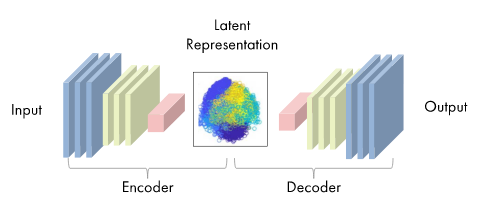
Autoencoders output a reconstruction of the input. The autoencoder consists of two smaller networks: an encoder and a decoder. During training, the encoder learns a set of features, known as a latent representation, from input data. At the same time, the decoder is trained to reconstruct the data based on these features. The autoencoder can then be applied to predict inputs not previously seen. Autoencoders are very generalizable and can be used on different data types, including images, time series, and text.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import *
from keras import backend as K


### Read in Data
The TMNIST database is a large database of handwritten digits that is commonly used for training various image processing systems. The dataset containe 94 characters and over 281,000 images which were normalized to fit into a 28x28 pixel bounding box and anti-aliased..

In [2]:
# tmnist data
df_train = pd.read_csv('94_character_TMNIST.csv')
X = df_train.iloc[:, 2:786]
print(X.shape)

(274093, 784)


In [3]:
df_train.head()

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,Salsa-Regular,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MouseMemoirs-Regular,D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Creepster-Regular,f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SeoulNamsan-Light,/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HachiMaruPop-Regular,F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


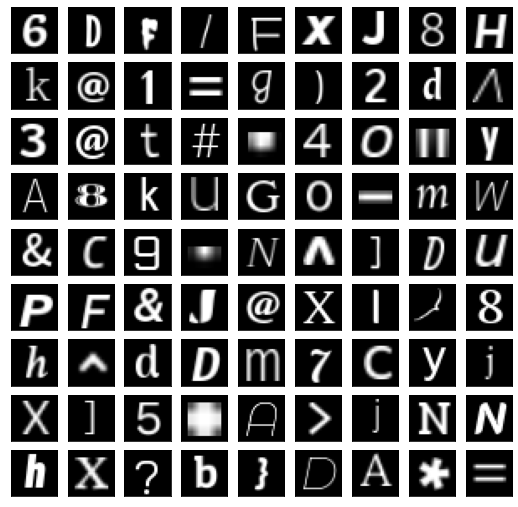

In [70]:
X_images = X.values.reshape(-1,28,28)
fig,axs = plt.subplots(9,9,figsize=(9,9))
for i in range(81):
    r=i//9
    c=i%9
    axs[r][c].set_xticks([])
    axs[r][c].set_yticks([])
    axs[r][c].imshow(X_images[i])
plt.gray()
plt.show()

### Set train set and test set

In [5]:
train_pct_index = int(0.75 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
X_train = X_train.values.astype('float32')/255.
X_test = X_test.values.astype('float32')/255.
output_X_train = X_train.reshape(-1,28,28,1)
output_X_test = X_test.reshape(-1,28,28,1)

print(X_train.shape, X_test.shape)

(205569, 784) (68524, 784)


### Build model
Autoencoders are an unsupervised learning technique in which we leverage neural networks for the task of representation learning. we'll design a neural network architecture such that we impose a bottleneck in the network which forces a compressed knowledge representation of the original input. If the input features were each independent of one another, this compression and subsequent reconstruction would be a very difficult task. However, if some sort of structure exists in the data, this structure can be learned and consequently leveraged when forcing the input through the network's bottleneck.

In the case we built a autoencoder model with 2 hidden layers and take tmnist data as input.
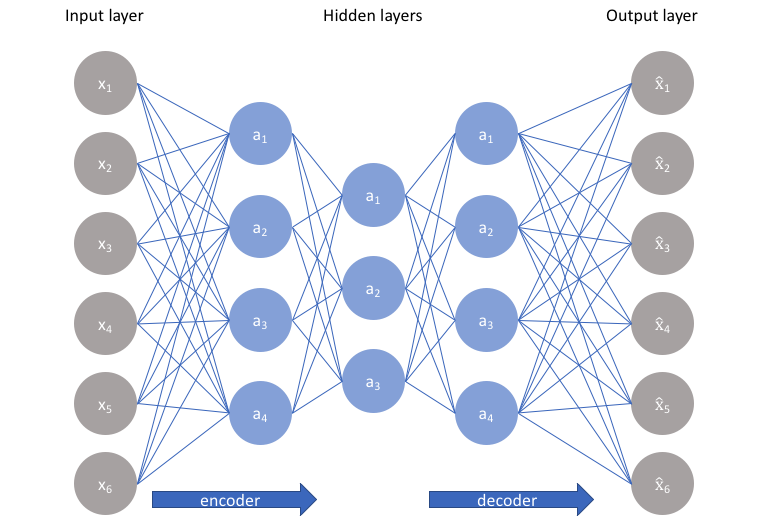
<b>Encoder</b>: Set of layers in the autoencoder architecture that are responsible for compressing the dimensions of input space to that of desired dimensions(latent space). In the figure above, encoder is part of network before the blue coloured nodes (latent space)

<b>Hidden Space</b>: Layer which maps the input space to lower dimensional space. Also, the layer with number of nodes equal to the desired number of features we want to extract from an autoencoder model.

<b>Decoder</b>: Set of layer in autoencoder that perform the tast of retreiving information from low dimensional latent space to the output layer. In the figure above, decoder is part of network after blue coloured nodes (latent space)

In [6]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

encoder_inputs = Input(shape = (28,28,1))
 
conv1 = Conv2D(16, (3,3), activation = 'relu', padding = "SAME")(encoder_inputs)
pool1 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv1)
conv2 = Conv2D(32, (3,3), activation = 'relu', padding = "SAME")(pool1)
pool2 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv2)
flat = Flatten()(pool2)
 
encoder_outputs = Dense(32, activation = 'relu')(flat)

In [7]:
#AE decoder
dense_layer_d = Dense(7*7*32, activation = 'relu')(encoder_outputs)
output_from_d = Reshape((7,7,32))(dense_layer_d)
conv1_1 = Conv2D(32, (3,3), activation = 'relu', padding = "SAME")(output_from_d)
upsampling_1 = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(conv1_1)
upsampling_2 = Conv2DTranspose(16, 3, padding='same', activation='relu', strides=(2, 2))(upsampling_1)
decoded_outputs = Conv2DTranspose(1, 3, padding='same', activation='relu')(upsampling_2)


### First modle

In [8]:
#AE
autoencoder = Model(encoder_inputs, decoded_outputs)
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 32)               

#### MaxPooling2D Layer
Max pooling operation for 2D spatial data. Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size ) for each channel of the input. The window is shifted by strides along each dimension.
#### Conv2d Layer
Keras Conv2D is a 2D Convolution Layer, this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.
#### Dense Layer
Keras Dense layer is the layer that contains all the neurons that are deeply connected within themselves. This means that every neuron in the dense layer takes the input from all the other neurons of the previous layer. We can add as many dense layers as required. It is one of the most commonly used layers.
#### Reshape
example, if reshape with argument (2,3) is applied to layer having input shape as (batch_size, 3, 2), then the output shape of the layer will be (batch_size, 2, 3) Reshape has one argument as follows − keras.layers.v(target_shape)
#### Conv2d_transpose Layer
Conv2DTranspose is a convolution operation whose kernel is learnt (just like normal conv2d operation) while training your model. Using Conv2DTranspose will also upsample its input but the key difference is the model should learn what is the best upsampling for the job.
Conv2D is mainly used when you want to detect features, e.g., in the encoder part of an autoencoder model, and it may shrink your input shape. Conversely, Conv2DTranspose is used for creating features, for example, in the decoder part of an autoencoder model for constructing an image.

In [9]:
batch_size = 1024
n_epoch = 10
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(output_X_train,output_X_train, epochs=n_epoch, 
                batch_size=batch_size, shuffle=True)


Epoch 1/10
201/201 [==============================] - 72s 357ms/step - loss: 0.3038
Epoch 2/10
201/201 [==============================] - 72s 356ms/step - loss: 0.1974
Epoch 3/10
201/201 [==============================] - 72s 356ms/step - loss: 0.1952
Epoch 4/10
201/201 [==============================] - 72s 356ms/step - loss: 0.1832
Epoch 5/10
201/201 [==============================] - 72s 357ms/step - loss: 0.1763
Epoch 6/10
201/201 [==============================] - 72s 360ms/step - loss: 0.1809
Epoch 7/10
201/201 [==============================] - 72s 357ms/step - loss: 0.1634
Epoch 8/10
201/201 [==============================] - 71s 355ms/step - loss: 0.1534
Epoch 9/10
201/201 [==============================] - 71s 356ms/step - loss: 0.1509
Epoch 10/10
201/201 [==============================] - 72s 356ms/step - loss: 0.1647


In [15]:
# Function for Plotting
def Plott (data):

    plt.plot(data.history['loss'], label =['loss'])
    plt.show()

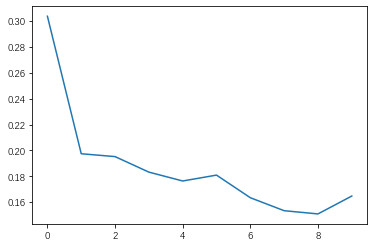

In [16]:
Plott(history)

In [14]:
test_imgs = autoencoder.predict(output_X_test)
print(test_imgs.shape)

(68524, 28, 28, 1)


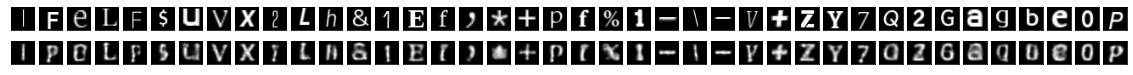

In [69]:
import matplotlib.pyplot as plt

n = 40
plt.figure(figsize=(20, 10))
for i in range(n):
    # display original
    ax = plt.subplot(16, n, i + 1)
    
    plt.imshow(output_X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(16, n, i + 1 + n)
    plt.imshow(test_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [45]:

encoder_inputs = Input(shape = (28,28,1))
 
conv1 = Conv2D(32, (3,3), activation = 'relu', padding = "SAME")(encoder_inputs)
pool1 = MaxPooling2D(pool_size = (4,4), strides = 2)(conv1)
conv2 = Conv2D(64, (3,3), activation = 'relu', padding = "SAME")(pool1)
pool2 = MaxPooling2D(pool_size = (4,4), strides = 2)(conv2)
flat = Flatten()(pool2)
 
encoder_outputs = Dense(64, activation = 'relu')(flat)

dense_layer_d = Dense(7*7*32, activation = 'relu')(encoder_outputs)
output_from_d = Reshape((7,7,32))(dense_layer_d)
conv1_1 = Conv2D(32, (3,3), activation = 'relu', padding = "SAME")(output_from_d)
upsampling_1 = Conv2DTranspose(128, 3, padding='same', activation='relu', strides=(2, 2))(conv1_1)
upsampling_2 = Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(upsampling_1)
decoded_outputs = Conv2DTranspose(1, 3, padding='same', activation='relu')(upsampling_2)

#AE
autoencoder = Model(encoder_inputs, decoded_outputs)
autoencoder.summary()

Model: "functional_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 13, 13, 64)        4672      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)              

### Modified Model

In [46]:
batch_size = 1024
n_epoch = 20
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(output_X_train,output_X_train, epochs=n_epoch, 
                batch_size=batch_size, shuffle=True)

Epoch 1/20
201/201 [==============================] - 124s 617ms/step - loss: 0.2576
Epoch 2/20
201/201 [==============================] - 126s 629ms/step - loss: 0.1821
Epoch 3/20
201/201 [==============================] - 127s 630ms/step - loss: 0.1819
Epoch 4/20
201/201 [==============================] - 126s 626ms/step - loss: 0.1751
Epoch 5/20
201/201 [==============================] - 126s 625ms/step - loss: 0.1574
Epoch 6/20
201/201 [==============================] - 124s 617ms/step - loss: 0.1505
Epoch 7/20
201/201 [==============================] - 126s 628ms/step - loss: 0.1676
Epoch 8/20
201/201 [==============================] - 123s 610ms/step - loss: 0.1529
Epoch 9/20
201/201 [==============================] - 122s 607ms/step - loss: 0.1400
Epoch 10/20
201/201 [==============================] - 123s 614ms/step - loss: 0.1410
Epoch 11/20
201/201 [==============================] - 124s 617ms/step - loss: 0.1349
Epoch 12/20
201/201 [==============================] - 123s 613

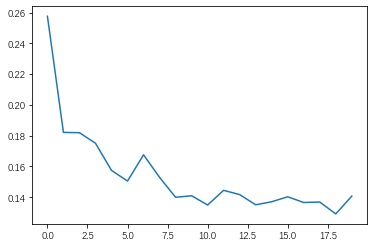

In [47]:
Plott(history)

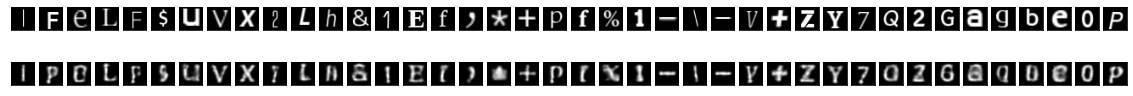

In [72]:
n = 40
plt.figure(figsize=(20, 20))
for i in range(n):
    # display original
    ax = plt.subplot(20, n, i + 1)
    
    plt.imshow(output_X_test[i].reshape(28, 28))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(20, n, i + 1 + n)
    plt.imshow(test_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [74]:
encoder_inputs = Input(shape = (28,28,1))
 
conv1 = Conv2D(16, (3,3), activation = 'relu', padding = "SAME")(encoder_inputs)
pool1 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv1)
conv2 = Conv2D(64, (3,3), activation = 'relu', padding = "SAME")(pool1)
pool2 = MaxPooling2D(pool_size = (2,2), strides = 2)(conv2)
flat = Flatten()(pool2)
 
encoder_outputs = Dense(64, activation = 'relu')(flat)
dense_layer_d = Dense(7*7*32, activation = 'relu')(encoder_outputs)
output_from_d = Reshape((7,7,32))(dense_layer_d)
conv1_1 = Conv2D(32, (3,3), activation = 'relu', padding = "SAME")(output_from_d)
upsampling_1 = Conv2DTranspose(64, 3, padding='same', activation='relu', strides=(2, 2))(conv1_1)
upsampling_2 = Conv2DTranspose(16, 3, padding='same', activation='relu', strides=(2, 2))(upsampling_1)
decoded_outputs = Conv2DTranspose(1, 3, padding='same', activation='relu')(upsampling_2)

#AE
autoencoder = Model(encoder_inputs, decoded_outputs)
autoencoder.summary()



Model: "functional_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 14, 14, 64)        9280      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 3136)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)              

In [75]:
batch_size = 128
n_epoch = 10
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(output_X_train,output_X_train, epochs=n_epoch, 
                batch_size=batch_size, shuffle=True)

Epoch 1/10
1607/1607 [==============================] - 109s 68ms/step - loss: 0.1776
Epoch 2/10
1607/1607 [==============================] - 107s 67ms/step - loss: 0.1437
Epoch 3/10
1607/1607 [==============================] - 106s 66ms/step - loss: 0.1299
Epoch 4/10
1607/1607 [==============================] - 106s 66ms/step - loss: 0.1300
Epoch 5/10
1607/1607 [==============================] - 102s 63ms/step - loss: 0.1295
Epoch 6/10
1607/1607 [==============================] - 101s 63ms/step - loss: 0.1312
Epoch 7/10
1607/1607 [==============================] - 101s 63ms/step - loss: 0.1376
Epoch 8/10
1607/1607 [==============================] - 101s 63ms/step - loss: 0.1260
Epoch 9/10
1607/1607 [==============================] - 101s 63ms/step - loss: 0.1225
Epoch 10/10
1607/1607 [==============================] - 101s 63ms/step - loss: 0.1295


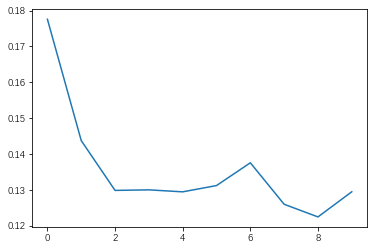

In [76]:
Plott(history)

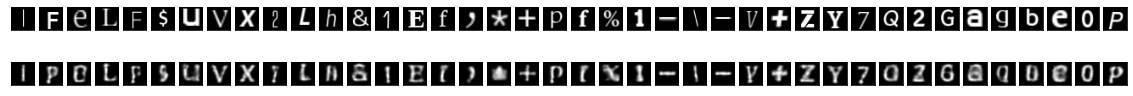

In [77]:
n = 40
plt.figure(figsize=(20, 20))
for i in range(n):
    # display original
    ax = plt.subplot(20, n, i + 1)
    
    plt.imshow(output_X_test[i].reshape(28, 28))
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(20, n, i + 1 + n)
    plt.imshow(test_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Trade-off between compression and quality

In the Notebook on autoencoders with the TMNIST dataset, I test 3 network architecture, In first model the nodes of layer is 16 & 32, the second model is 32 & 64, in third model is 16 & 64.The third has the best performance.Contrary to intuition, Larger networks do not always give the best results, So the Trade-off is that  first layers is larger and last layers is smaller may get better performance. We should compress between 2 conv2d to improve generation quality

### Reference
https://www.jeremyjordan.me/autoencoders/
https://socr.umich.edu/HTML5/ABIDE_Autoencoder/#:~:text=We%20will%20design%20the%20deep,most%20useful%20combinations%20of%20features.
Ngoc, Kien& Hwang, Myunggwon: Finding the Best k for the Dimension of the Latent Space in Autoencoders DOI: 10.1007/978-3-030-63007-2_35
https://keras.io/api/

### Copyright
Copyright <2022> <Zeyuan Zhu>

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.